<a href="https://colab.research.google.com/github/davekooi/Michigan_bird_classifier/blob/main/Michigan_Bird_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U duckduckgo_search fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 16.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images = 30):
    print(f"Searching for {keywords}")
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('great blue heron photos', max_images=1)
urls[0]

Searching for great blue heron photos


'http://tx.audubon.org/sites/g/files/amh541/f/styles/bean_wysiwyg_full_width/public/great-blue-heron_rebecca-field.jpg?itok=oSQB_ZLO'

In [ ]:
from fastdownload import download_url
from fastai.vision.all import *

Searching for great blue heron photos


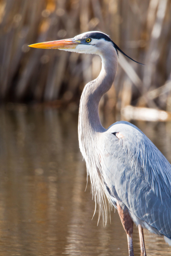

In [ ]:
dest = 'gbh.jpg'
full_bird_name = 'great blue heron'
download_url(search_images(f'{full_bird_name} photos', max_images=1)[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

Searching for sparrow photos


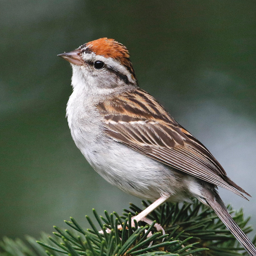

In [ ]:
dest = 'sparrow.jpg'
full_bird_name = 'sparrow'
download_url(search_images(f'{full_bird_name} photos', max_images=1)[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

Searching for downy woodpecker photos


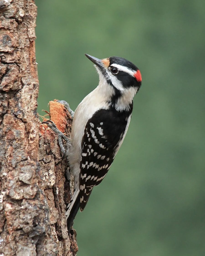

In [ ]:
dest = 'downy_woodpecker.jpg'
full_bird_name = 'downy woodpecker'
download_url(search_images(f'{full_bird_name} photos', max_images=1)[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

In [ ]:
searches = 'great_blue_heron','sparrow', 'american_robin', 'hairy_woodpecker', 'downy_woodpecker'
path = Path('birds')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o.replace("_", " ")} photo', max_images=150))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for great blue heron photo
Searching for sparrow photo
Searching for american robin photo
Searching for hairy woodpecker photo
Searching for downy woodpecker photo


In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

In [ ]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

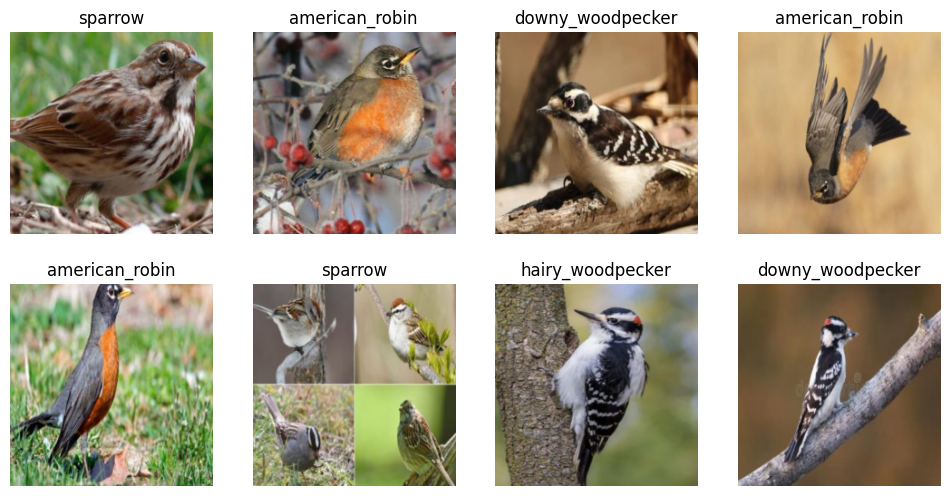

In [ ]:
dls = birds.dataloaders(path, bs=32)

dls.valid.show_batch(max_n=8)

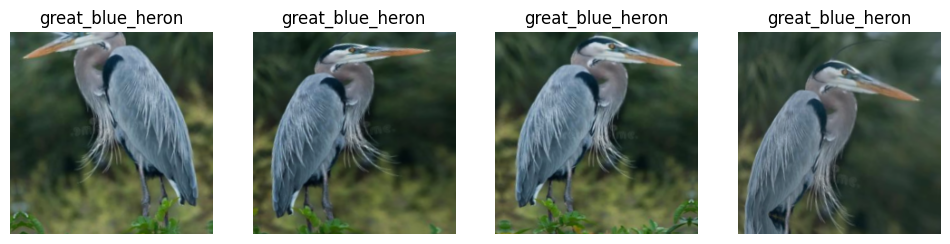

In [ ]:
# unique as true is showing the same image for different data augmentations (croping in this case)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.386070,0.361936,0.169014,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.434712,0.405383,0.161972,00:03
1,0.398416,0.381980,0.147887,00:03
2,0.333345,0.422902,0.119718,00:03
3,0.295538,0.492567,0.098592,00:03
4,0.257781,0.432453,0.105634,00:04
5,0.214570,0.408937,0.091549,00:03
6,0.185267,0.372798,0.091549,00:03
7,0.156325,0.406627,0.119718,00:03
8,0.133594,0.425287,0.112676,00:04
9,0.120947,0.403892,0.084507,00:03


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
label,_,probs = learn.predict(PILImage.create('sparrow.jpg'))
print(f"This is a: {label}.")
print(probs)

This is a: sparrow.
tensor([9.4708e-08, 3.7119e-08, 1.1133e-08, 7.1036e-10, 1.0000e+00])


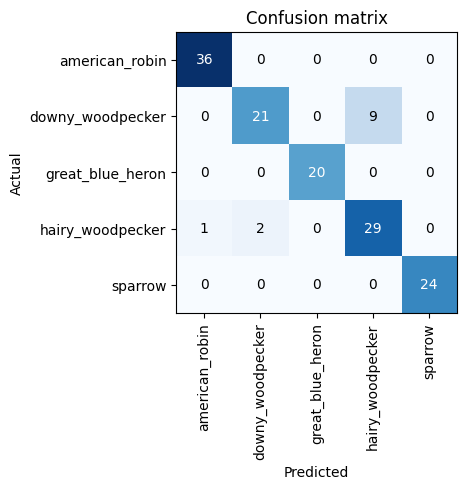

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


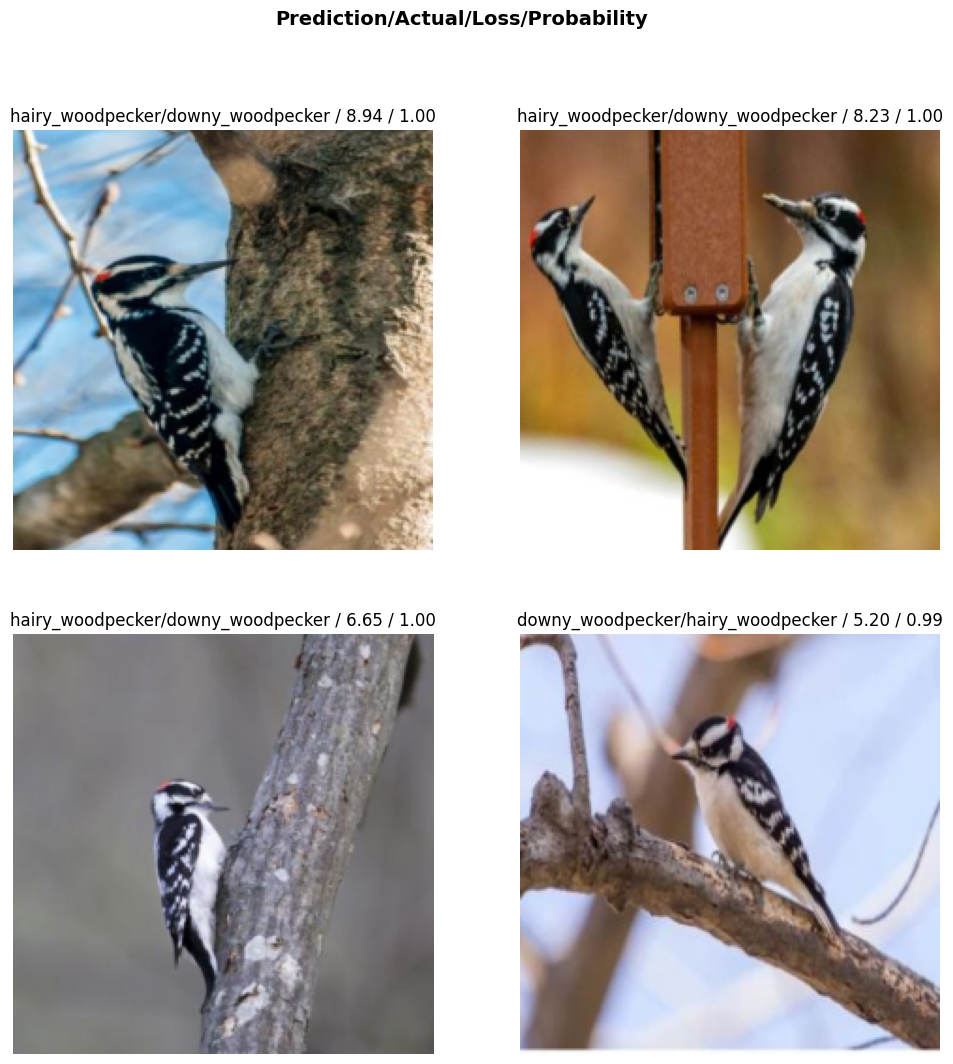

In [ ]:
interp.plot_top_losses(4, figsize=(12,12))


In [ ]:
learn.export("model.pkl")